# Dependencies
First, we check that the notebook is setup for rendering the simulations!

In [1]:
try:
    import webgui_jupyter_widgets
    from packaging.version import parse
    assert parse(webgui_jupyter_widgets.__version__) >= parse("0.2.18")
    print('Everything good!')
except:
    print("\x1b[31mYou need to update webgui_jupyter_widgets by running: \x1b[0m\npython3 -m pip install --upgrade webgui_jupyter_widgets")

Everything good!


Now we import the ngsolve library that we will use for the simulations.

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *   # Opencascade for geometry modeling

# Setting up the Simulation

The first task is to setup a mesh that we can simulate our equations on.

## The geometry
We're going to look at conduction inside a circle (imagine a slice from a steel bar), with convection on the outside. So lets create a circular mesh.

In [3]:
# Make a radius 1 circle
geom = Circle((0,0), 1).Face()
geom.edges.name = "outeredge"
# Turn it into a 2D mesh, with triangles with a maximum edge length of 0.1
mesh = Mesh(OCCGeometry(geom, dim=2).GenerateMesh(maxh=0.1))
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## The equations

We now need to generate a finite element space where we're going to solve our
equations on. This is different to the mesh, as the points of the mesh might be
mapped onto the equations in many different ways.

In [4]:
fes = H1(mesh, order=2)
fes.ndof

1442

The equations themselves are the heat diffusion equation
$$
\rho\,C_p\frac{\partial T}{\partial t} = -\rho\,C_p\,\bm{v}
  \cdot\nabla\,T - \nabla\cdot\bm{q} - \bm{\tau}:\nabla\,\bm{v} -
  p\,\nabla\cdot\bm{v} +\sigma_{energy}
$$

which for stationary solids $\bm{v}=0$, becomes

$$
\rho\,C_p\frac{\partial T}{\partial t} = - \nabla\cdot\bm{q} +\sigma_{energy}
$$

Inserting fourier's law,
$$
\rho\,C_p\frac{\partial T}{\partial t} = \nabla\cdot k\nabla\bm{T} +\sigma_{energy}
$$

To make this a finite element problem, we define a trial function $v$ we
"project" this equation onto. We are creating the so-called weak form of the
equation where it applies to a test function.

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega - \int_{\Omega} (\nabla\cdot k\nabla\bm{T})\,v\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega
$$

where the volume integrals are over the domain $\Omega$.

We need to create an identity here to help us with the next step.

### The identity
The first identity we need is divergence theorem

$$ \int_\Omega \nabla\cdot\bm{F}\,{\rm d}\Omega = \int_{d\Omega} \bm{F}\cdot\hat{n}\,{\rm d}S $$

where the RHS is a surface integral. To make the identity we need, we make the substitution $\bm{F}\to v\nabla u$.

$$ \int_\Omega \nabla\cdot (v\nabla u)\,{\rm d}\Omega = \int_{d\Omega} (v\nabla u)\cdot\hat{n}\,{\rm d}S $$

Expanding the LHS

$$ \int_\Omega (\nabla v) \cdot (\nabla u)\,{\rm d}\Omega + \int_\Omega v\,\nabla\cdot\nabla u\,{\rm d}\Omega = \int_{d\Omega} (v\nabla u)\cdot\hat{n}\,{\rm d}S $$

We note the RHS is a projection of the derivatives onto the normal direction, so we write

$$ \int_\Omega (\nabla v) \cdot (\nabla u)\,{\rm d}\Omega + \int_\Omega v\,\nabla\cdot\nabla u\,{\rm d}\Omega = \int_{d\Omega} v \frac{\partial u}{\partial n}\,{\rm d}S $$

Then we rearrange into the exact form we need

$$ \int_\Omega (\nabla\cdot\nabla u)\,v\,{\rm d}\Omega = \int_{d\Omega} v \frac{\partial u}{\partial n}\,{\rm d}S - \int_\Omega (\nabla v) \cdot (\nabla u)\,{\rm d}\Omega $$

### The final weak form

Using this identity we can split out the fourier term

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega - \int_{\Omega} (\nabla\cdot k\nabla\bm{T})\,v\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega
$$

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega - \int_{d\Omega} v k\frac{\partial T}{\partial n}\,{\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T)\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\bm{r}
$$


### Inserting a Robin boundary condition
Lets use a heat transfer coefficient for the BC

$$
-k\frac{\partial T}{\partial n}=  h (T - T_\infty)
$$

Inserting

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega + \int_{d\Omega} v\,h\,(T - T_\infty){\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T)\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\bm{r}
$$

Splitting this into linear (RHS, terms without $T$) and bilinear (LHS, terms with $T$) halves

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega + \int_{d\Omega} v\,h\,T{\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T)\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega +\int_{d\Omega} v\,h\,T_\infty{\rm d}S
$$


## Steady State solution

Lets setup a simulation that solves for the steady state first. Below we create the trial ($u=T$) and test ($v$) functions, then set up the bilinear terms (LHS above, all terms involving the trial function T) and the linear terms (all other terms on RHS). Then we solve.

Here we have heat generation $\sigma=2$ just to get a steady state that is something other than a flat temperature profile.

In [41]:
T, v = fes.TnT()
k=1
h=1
sigma = 2
Tinf = 5

a = BilinearForm(fes) # This is the LHS of the equation, without the time derivative
a += grad(v) * k * grad(T)*dx
a += v * h * T * ds("outeredge") 
a.Assemble()

# Now this is the RHS of the equation
f = LinearForm(sigma * v * dx + v * h * Tinf * ds("outeredge")).Assemble()

# Here we solve it using a matrix inversion
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse() * f.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## Unsteady state solution

For unsteady state we need to get a weak form of the time integration. Start with the full expression:

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega + \int_{d\Omega} v\,h\,T{\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T)\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega +\int_{d\Omega} v\,h\,T_\infty{\rm d}S
$$

We note that when we apply our discretization (insert the test function $v$), we will get a series of matrices. We will identify the standard matrices

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega + \bm{A}\cdot \bm{T} =  \bm{f}
$$

where $\bm{T}$ is our solution coefficients. We make an implicit Euler approximation

$$
\int_{\Omega} \rho\,C_p\frac{T_{n+1} - T_{n}}{\Delta t} v \,{\rm d}\Omega + \bm{A}\cdot \bm{T}_{n+1} =  \bm{f}
$$

And note that the same operation is happening on the left, so there's one common so-called mass matrix $\bm{M}$ that will result,

$$
\bm{M}\cdot \left(\bm{T}_{n+1} - \bm{T}_{n}\right) + \bm{A}\cdot \bm{T}_{n+1} =  \bm{f}
$$

where,

$$
\bm{M} = \int_{\Omega} \frac{\rho\,C_p}{\Delta t}T\,v \,{\rm d}\Omega 
$$

Rearranging,

$$
\left(\bm{M} + \bm{A}\right)\cdot\bm{T}_{n+1} =  \bm{f} + \bm{M}\cdot \bm{T}_{n}
$$

Or defining $\bm{P} = \left(\bm{M} + \bm{A}\right)$,

$$
\bm{P}\cdot\bm{T}_{n+1} =  \bm{f} + \bm{M}\cdot \bm{T}_{n}
$$

The solution is then

$$
\bm{T}_{n+1} =  \bm{P}^{-1}\cdot \left(\bm{f} + \bm{M}\cdot \bm{T}_{n}\right)
$$


Biot number: 0.05


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Text(0.5, 1.0, 'Bi=0.05')

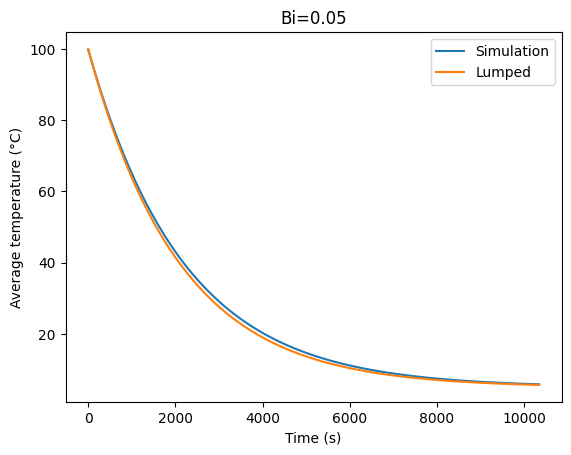

In [40]:
# Coefficients for the simulation
rho = 1000 # Density
Cp = 4.18 # Heat capacity
T0 = 100 # Initial temperature
k=10 # Thermal conductivity
h= 1# External heat transfer coefficient
Tinf = 5 # External temperature
R = 1 # Radius of the circle
sigma = 0 # Heat source term
# Simulation duration and time step is defined in terms of tau
tau_end = 5
dtau = tau_end / 100 
tend = 10000 # End time
Render_Frames = 100 # Number of frames to render

# Compute when to take snapshots
save_every = tend / dt / Render_Frames

# Compute external heat transfer Area
pi = 3.14159265359
A_ext = 2 * pi * R # * L
# Compute volume
V = pi * R**2 # * L
# Compute characteristic length
L = V / A_ext
# Compute Biot number
Bi = h * L / k
print(f"Biot number: {Bi}")


tau = rho * Cp * V / h / A_ext
tend = tau_end * tau
dt = dtau * tau

#### Build of the geometry and mesh
# Make a circle
geom = Circle((0,0), R).Face()
geom.edges.name = "outeredge"
# Turn it into a 2D mesh, with triangles with a maximum edge length of 0.1
mesh = Mesh(OCCGeometry(geom, dim=2).GenerateMesh(maxh=0.1))

# We now need to define the type of functions that are going to be used over the
# mesh 
fes = H1(mesh, order=2)


#### Build of the weak form of the governing equations
A = BilinearForm(fes, symmetric=False) # We need symmetric=False to make sure the sparsity pattern is correct
A += v * h * T * ds("outeredge") 
A += grad(v) * k * grad(T)*dx
A.Assemble()

M = BilinearForm(fes, symmetric=False)
M += rho / dt * Cp * T * v * dx
M.Assemble()

# Now this is the RHS of the equation
f = LinearForm(fes)
f += sigma*v*dx 
f += v * h * Tinf * ds("outeredge")
f.Assemble()

P = M.mat.CreateMatrix()
P.AsVector().data = M.mat.AsVector() + A.mat.AsVector()
invP = P.Inverse(freedofs=fes.FreeDofs())

#### Time integration
# Prepare the time integration starting point
time = 0
step_idx = 0
# T_last is the current solution to the temperature field
T_last = GridFunction(fes)
T_last.Set(T0) # Set the initial condition
# Prepare the live visualization
scene = Draw(T_last, mesh, "T", min=Tinf, max=T0)
# Store the history of the temperature for visualization
T_history = GridFunction(T_last.space, multidim=0)
T_history.AddMultiDimComponent(T_last.vec)
# Time integration loop
T_avg_list = []
while time < tend - dt/2:
    # Test if we need to save the current state
    if step_idx % save_every == 0:
        T_history.AddMultiDimComponent(T_last.vec)

    # Compute the average temperature
    T_avg = Integrate(T_last, mesh) / V
    T_avg_list.append((time, T_avg))
    # Perform the time integration
    T_last.vec.data = invP * (f.vec + M.mat * T_last.vec)
    # Redraw the visualization
    scene.Redraw()

    # Update the time and step index
    time += dt
    step_idx += 1

# Save animation here
# https://docu.ngsolve.org/latest/i-tutorials/appendix-vtk/vtk.html

from matplotlib import pyplot as plt
%matplotlib inline
time = [t for t, T in T_avg_list]
T_sim = [T for t, T in T_avg_list]
plt.plot(time, T_sim, label="Simulation")
#Draw(T_history, mesh, interpolate_multidim=False, min=Tinf, max=T0, animate=True, speed=10)
T_lumped = [Tinf + (T0 - Tinf) * exp(-t / tau) for t in time]
plt.plot(time, T_lumped, label="Lumped")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Average temperature (°C)")
plt.title(f"Bi={Bi}")

## Appendix: Doing it without the matrix math

The first time I solved this, I left the time-stepping in the weak form construction. It works but is inefficient. Start with the full expression:

$$
\int_{\Omega} \rho\,C_p\frac{\partial T}{\partial t} v \,{\rm d}\Omega + \int_{d\Omega} v\,h\,T{\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T)\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega +\int_{d\Omega} v\,h\,T_\infty{\rm d}S
$$

We replace the time derivative with an implicit Euler, which means that all
temperatures are now evalulated in the next time step. Implicit Euler is chosen
as its generally quite stable compared to other schemes, but needs a full
inversion to work.

$$
\int_{\Omega} \rho\,C_p\frac{\left(T_{n+1} - T_{n}\right)}{\Delta t} v \,{\rm d}\Omega + \int_{d\Omega} v\,h\,T_{n+1}{\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T_{n+1})\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega +\int_{d\Omega} v\,h\,T_\infty{\rm d}S
$$

The term involving the previous time step is now no-longer a function of the current trial function $T_{n+1}$ so we move it over to the linear side.

$$
\int_{\Omega} \rho\,C_p\frac{T_{n+1}}{\Delta t} v \,{\rm d}\Omega + \int_{d\Omega} v\,h\,T_{n+1}{\rm d}S + \int_\Omega (\nabla v) \cdot (k\nabla T_{n+1})\,{\rm d}\Omega =  \int_{\Omega}\sigma_{energy}\,v\,{\rm d}\Omega +\int_{d\Omega} v\,h\,T_\infty{\rm d}S + \int_{\Omega} \rho\,C_p\frac{T_{n}}{\Delta t} v \,{\rm d}\Omega
$$


$$
\int_{\Omega} \left[\rho\,C_p\frac{T_{n+1}}{\Delta t} v+(\nabla v) \cdot (k\nabla T_{n+1})\right]\,{\rm d}\Omega  + \int_{d\Omega} v\,h\,T_{n+1}\,{\rm d}S =  \int_{\Omega}\left[\sigma_{energy}\,v +\rho\,C_p\frac{T_{n}}{\Delta t} v\right]{\rm d}\Omega +\int_{d\Omega} v\,h\,T_\infty{\rm d}S 
$$


In [8]:
# This is an example of taking one step in time the "proper way"
T_last = GridFunction(fes)
T_last.Set(100)

rho = 1000
Cp = 4.18
dt = 0.1

a = BilinearForm(fes) # This is the LHS of the equation, WITH time derivatives
a += (rho / dt * Cp) * T * v * dx
a += grad(v) * k * grad(T)*dx
a += v * h * T * ds("outeredge") 
a.Assemble()

# Now this is the RHS of the equation
f = LinearForm(fes)
f += sigma*v*dx 
f += v * h * Tinf * ds("outeredge")
f += rho * Cp / dt * T_last * v * dx 
f.Assemble()

# Here we solve it using a matrix inversion
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse() * f.vec

scene = Draw(gfu, mesh, "T")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…